# 2252621 - Nguyen Quang Phu 

This notebook is run on Python10

# Home Exercise on Language Modeling

Implement a **transformer** to solve the **Language Modeling** task.

- **Data**: [wikitext-103](https://huggingface.co/datasets/Salesforce/wikitext)
- **Loading with Hugging Face Datasets**:
  ```python
  from datasets import load_dataset
  dataset = load_dataset("wikitext", "wikitext-103-v1")
  ```

**Note**: Submit only a **single Jupyter Notebook file** that can handle all tasks, including **data downloading, preprocessing, model training, and model evaluation**. (Submissions that do not follow the guidelines will receive a score of 0.)

## Grading Criteria

For valid submissions, scores will be assigned based on the **leaderboard ranking** (**strictly greater**):

- **Top 25%** → **10 points**
- **25% - 50%** → **9.0 points**
- **50% - 75%** → **8.0 points**
- **75% - 100%** → **7.0 points**


# Import

In [ ]:
# %pip install torch numpy pandas gdown datasets rouge

!pip install pandas==2.2.3
!pip install numpy==1.26.4
!pip install seaborn==0.12.2
!pip install nltk==3.2.4
!pip install torch==2.5.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
!pip install rouge
!pip install tqdm
!pip install matplotlib  # uncomment if you want version output
!pip install scikit-learn  # uncomment if you want sklearn version
!pip install tensorflow  # for keras Tokenizer and pad_sequences
!pip install datasets 
!pip install gdown


Note: you may need to restart the kernel to use updated packages.


===== Library Versions =====

Python:        3.10.12

Torch:         2.5.1+cu121

NumPy:         1.26.4

Pandas:        2.2.3

gdown:         5.2.0

datasets:      3.3.1

nltk:          3.2.4

matplotlib:    3.7.5

seaborn:       0.12.2

scikit-learn:  1.2.2

TensorFlow:    2.17.1

transformers:  4.47.0

rouge:         <module 'rouge' from '/usr/local/lib/python3.10/dist-packages/rouge/__init__.py'>

============================

In [ ]:
# ===============================
# Print Versions of Key Libraries
# ===============================
import sys
import torch
import numpy as np
import pandas as pd
import gdown
import datasets
import nltk
import matplotlib
import seaborn
import sklearn
import tensorflow
import transformers
import rouge

print("\n===== Library Versions =====")
print(f"Python:        {sys.version.split()[0]}")
print(f"Torch:         {torch.__version__}")
print(f"NumPy:         {np.__version__}")
print(f"Pandas:        {pd.__version__}")
print(f"gdown:         {gdown.__version__}")
print(f"datasets:      {datasets.__version__}")
print(f"nltk:          {nltk.__version__}")
print(f"matplotlib:    {matplotlib.__version__}")
print(f"seaborn:       {seaborn.__version__}")
print(f"scikit-learn:  {sklearn.__version__}")
print(f"TensorFlow:    {tensorflow.__version__}")
print(f"transformers:  {transformers.__version__}")
print(f"rouge:         {rouge}")
print("============================\n")

In [ ]:
# ====================================
# Import necessary libraries
# ====================================

# Standard Libraries
import os
import re
import math
import random
import itertools
import warnings
from math import ceil

# Data Handling & Processing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# NLP Libraries & Tokenizers
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer

# Evaluation Metrics
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

# PyTorch Utilities
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# External Data Handling
import gdown
from datasets import load_dataset

# Warnings and Display Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
tqdm.pandas()

# ====================================
# Download NLTK Data
# ====================================
nltk.download("stopwords")
nltk.download("punkt")

# ====================================
# Check if GPU is available
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from transformers import get_cosine_schedule_with_warmup

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [4]:
# # https://drive.google.com/drive/folders/12QPunWPqA9U457jhcK8GyBmjsKvdPdCL?usp=sharing
# # URL of the shared folder
# folder_url = "https://drive.google.com/drive/folders/12QPunWPqA9U457jhcK8GyBmjsKvdPdCL?usp=sharing"

# # Output directory where the folder will be saved
# # output_dir = "Lab11"

# # Download the folder
# gdown.download_folder(folder_url, quiet=False)

# Get dataset

In [5]:
dataset = load_dataset("wikitext", "wikitext-103-v1")
train_texts = [line for line in dataset['train']['text'] if line.strip()]
val_texts   = [line for line in dataset['validation']['text'] if line.strip()]
test_texts  = [line for line in dataset['test']['text'] if line.strip()]


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [7]:
len(train_texts), len(val_texts), len(test_texts)

(1165029, 2461, 2891)

In [8]:
train_texts[:5]

[' = Valkyria Chronicles III = \n',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for serie

# Analyze data

In [9]:
def visualize_sentence_lengths(data, split='None', max_bins=100):
    """
    Visualizes the distribution of sentence lengths (in words).
    
    Args:
        data (DatasetDict or list): Either Hugging Face DatasetDict or list of strings.
        split (str): Dataset split to analyze (e.g., 'train', 'test', 'validation', or 'None').
        max_bins (int): Max number of bins in the histogram.
    """
    if isinstance(data, dict) or "DatasetDict" in str(type(data)):
        dataset = data[split] if split != 'None' else data
        texts = [row['text'] for row in dataset if row['text'].strip()]
    elif isinstance(data, list):
        texts = [text for text in data if text.strip()]
    else:
        raise ValueError("Unsupported input type: must be list of strings or DatasetDict")

    word_counts = [len(text.split()) for text in texts]

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.hist(word_counts, bins=max_bins, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of Sentence Lengths in `{split}` Split")
    plt.xlabel("Number of Words per Sentence")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Print stats
    print(f"📈 Stats for `{split}` split:")
    print(f"  - Total samples: {len(word_counts)}")
    print(f"  - Mean sentence length: {sum(word_counts)/len(word_counts):.2f}")
    print(f"  - Max sentence length: {max(word_counts)}")
    print(f"  - Min sentence length: {min(word_counts)}")


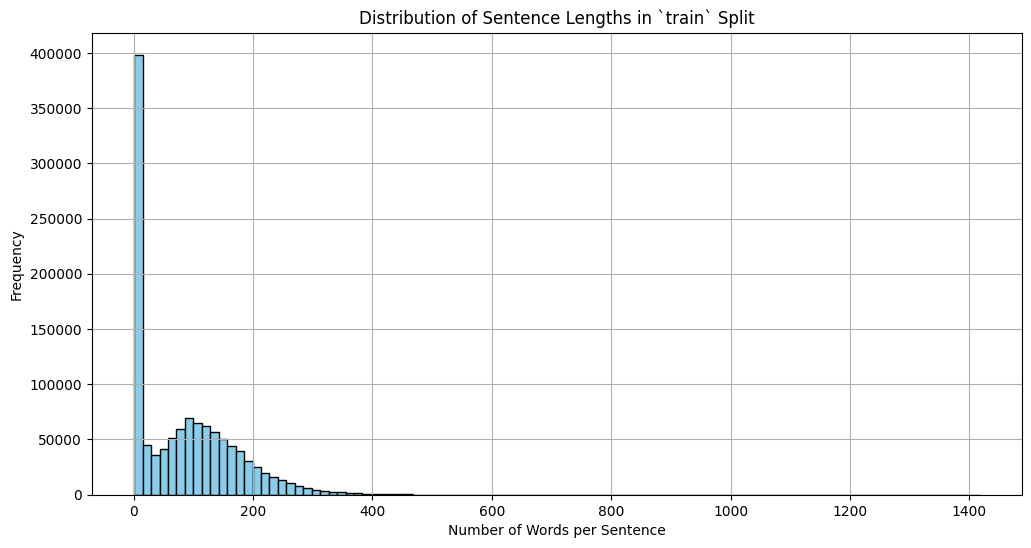

📈 Stats for `train` split:
  - Total samples: 1165029
  - Mean sentence length: 87.06
  - Max sentence length: 1417
  - Min sentence length: 1


In [10]:
visualize_sentence_lengths(dataset, split='train')

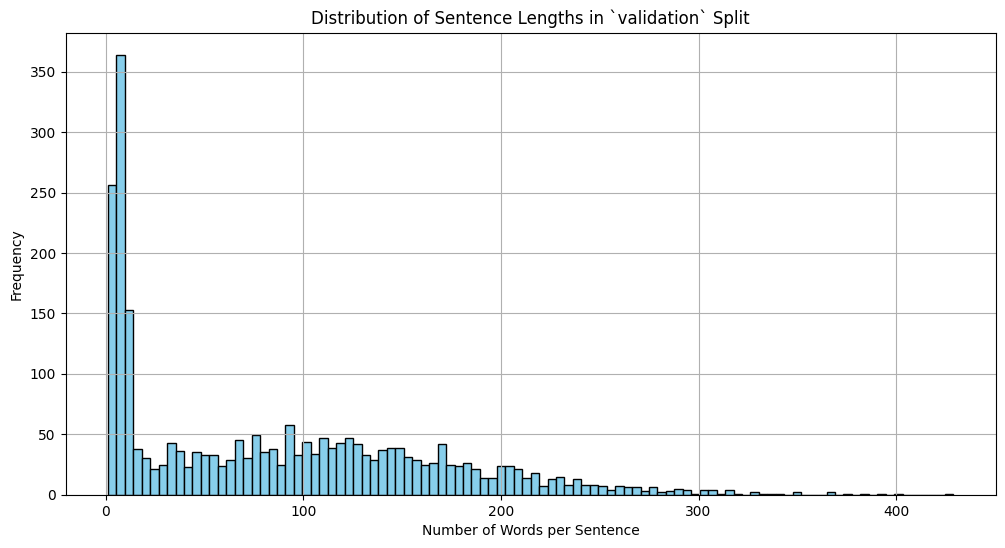

📈 Stats for `validation` split:
  - Total samples: 2461
  - Mean sentence length: 86.91
  - Max sentence length: 429
  - Min sentence length: 1


In [11]:
visualize_sentence_lengths(dataset, split='validation')

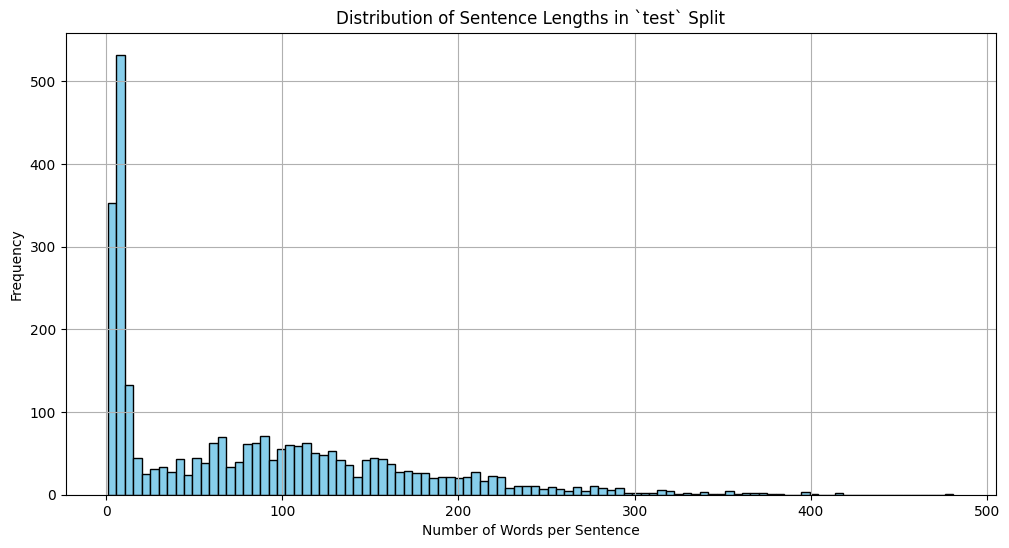

📈 Stats for `test` split:
  - Total samples: 2891
  - Mean sentence length: 83.44
  - Max sentence length: 481
  - Min sentence length: 1


In [12]:
visualize_sentence_lengths(dataset, split='test')

In [13]:
def compute_length_coverage(data, split='None', max_len=512):
    """
    Compute what % of rows have word count <= max_len.

    Args:
        data (DatasetDict or list): Either HF DatasetDict or list of strings
        split (str): 'train', 'validation', 'test' (if HF dataset), or 'None' if list
        max_len (int): Word count threshold

    Returns:
        float: percentage of samples with length <= max_len
    """
    if isinstance(data, dict) or "DatasetDict" in str(type(data)):
        dataset = data[split] if split != 'None' else data
        texts = [row['text'] for row in dataset if row['text'].strip()]
    elif isinstance(data, list):
        texts = [text for text in data if text.strip()]
    else:
        raise ValueError("Unsupported input type: must be list of strings or DatasetDict")

    word_counts = [len(text.split()) for text in texts]
    total = len(word_counts)
    within_limit = sum(wc <= max_len for wc in word_counts)
    percentage = (within_limit / total) * 100

    print(f"✅ {within_limit}/{total} samples (≈ {percentage:.2f}%) in `{split}` are ≤ {max_len} words.")
    return percentage


In [14]:
compute_length_coverage(dataset, split='train', max_len=256)
compute_length_coverage(dataset, split='validation', max_len=256)
compute_length_coverage(dataset, split='test', max_len=256)


✅ 1121912/1165029 samples (≈ 96.30%) in `train` are ≤ 256 words.
✅ 2389/2461 samples (≈ 97.07%) in `validation` are ≤ 256 words.
✅ 2788/2891 samples (≈ 96.44%) in `test` are ≤ 256 words.


96.43721895537875

In [15]:
compute_length_coverage(dataset, split='train', max_len=5)
compute_length_coverage(dataset, split='validation', max_len=5)
compute_length_coverage(dataset, split='test', max_len=5)


✅ 121161/1165029 samples (≈ 10.40%) in `train` are ≤ 5 words.
✅ 256/2461 samples (≈ 10.40%) in `validation` are ≤ 5 words.
✅ 353/2891 samples (≈ 12.21%) in `test` are ≤ 5 words.


12.210307851954342

In [16]:
MAX_LEN = 256 

In [17]:
def remove_headers_and_markups(text):
    # Remove wiki-style headers like == Header ==
    text = re.sub(r"=+\s*[^=]+?\s*=+", "", text)
    # Remove <unk> tokens
    text = re.sub(r"<unk>", "", text)
    return text

def remove_links_and_tags(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove HTML/XML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove @mentions or hashtags
    text = re.sub(r"[@#]\w+", "", text)
    return text

def remove_special_characters(text):
    # Keep only letters, numbers, and selected punctuation
    return re.sub(r"[^a-zA-Z0-9\s.,;!?\"'\[\]\-]", "", text)

def normalize_whitespace(text):
    return re.sub(r"\s+", " ", text).strip()

def to_lower(text):
    return text.lower()

def length_filter(text, min_len=5, max_len=MAX_LEN):
    return min_len <= len(text.split()) <= max_len

def preprocess_text(text):
    text = remove_headers_and_markups(text)
    text = remove_links_and_tags(text)
    text = remove_special_characters(text)
    text = normalize_whitespace(text)
    text = to_lower(text)
    return text

In [18]:
train_texts = [preprocess_text(line) for line in dataset['train']['text'] if line.strip()]
val_texts   = [preprocess_text(line) for line in dataset['validation']['text'] if line.strip()]
test_texts  = [preprocess_text(line) for line in dataset['test']['text'] if line.strip()]


In [19]:
train_texts[:5]

['',
 'senj no valkyria 3 chronicles japanese 3 , lit . valkyria of the battlefield 3 , commonly referred to as valkyria chronicles iii outside japan , is a tactical role - playing video game developed by sega and media.vision for the playstation portable . released in january 2011 in japan , it is the third game in the valkyria series . employing the same fusion of tactical and real - time gameplay as its predecessors , the story runs parallel to the first game and follows the " nameless " , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit " raven " .',
 "the game began development in 2010 , carrying over a large portion of the work done on valkyria chronicles ii . while it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . character designer honjou and composer hitoshi sakimoto b

In [20]:
val_texts[:5]

['',
 'homarus gammarus , known as the european lobster or common lobster , is a species of clawed lobster from the eastern atlantic ocean , mediterranean sea and parts of the black sea . it is closely related to the american lobster , h. americanus . it may grow to a length of 60 cm 24 in and a mass of 6 kilograms 13 lb , and bears a conspicuous pair of claws . in life , the lobsters are blue , only becoming " lobster red " on cooking . mating occurs in the summer , producing eggs which are carried by the females for up to a year before hatching into planktonic larvae . homarus gammarus is a highly esteemed food , and is widely caught using lobster pots , mostly around the british isles .',
 'description',
 'homarus gammarus is a large crustacean , with a body length up to 60 centimetres 24 in and weighing up to 5 6 kilograms 11 13 lb , although the lobsters caught in lobster pots are usually 23 38 cm 9 15 in long and weigh 0 . 7 2 . 2 kg 1 . 5 4 . 9 lb . like other crustaceans , lobs

In [21]:
test_texts[:5]

['',
 'robert boulter is an english film , television and theatre actor . he had a guest - starring role on the television series the bill in 2000 . this was followed by a starring role in the play herons written by simon stephens , which was performed in 2001 at the royal court theatre . he had a guest role in the television series judge john deed in 2002 . in 2004 boulter landed a role as " craig " in the episode " teddy \'s story " of the television series the long firm ; he starred alongside actors mark strong and derek jacobi . he was cast in the 2005 theatre productions of the philip ridley play mercury fur , which was performed at the drum theatre in plymouth and the chocolate factory in london . he was directed by john tiffany and starred alongside ben whishaw , shane zaza , harry kent , fraser ayres , sophie stanton and dominic hall .',
 'in 2006 , boulter starred alongside whishaw in the play citizenship written by mark ravenhill . he appeared on a 2006 episode of the televis

In [22]:
compute_length_coverage(train_texts, split='None', max_len=256)
compute_length_coverage(val_texts, split='None', max_len=256)
compute_length_coverage(test_texts, split='None', max_len=256)


✅ 973187/1012275 samples (≈ 96.14%) in `None` are ≤ 256 words.
✅ 2099/2162 samples (≈ 97.09%) in `None` are ≤ 256 words.
✅ 2424/2517 samples (≈ 96.31%) in `None` are ≤ 256 words.


96.30512514898689

In [23]:
compute_length_coverage(train_texts, split='None', max_len=5)
compute_length_coverage(val_texts, split='None', max_len=5)
compute_length_coverage(test_texts, split='None', max_len=5)


✅ 193447/1012275 samples (≈ 19.11%) in `None` are ≤ 5 words.
✅ 398/2162 samples (≈ 18.41%) in `None` are ≤ 5 words.
✅ 521/2517 samples (≈ 20.70%) in `None` are ≤ 5 words.


20.699245133094955

Base on all the analysis, we see that the train and val data in length [5, 256] could be anough for train, if use more we could exceed the limit of 12 hours of training on kaggle

In [24]:
MAX_LEN_WORDS = 256
MIN_LEN_WORDS = 5

def filter_texts_by_word_length(texts, min_len=5, max_len=100):
    return [
        line for line in texts 
        if line.strip() and min_len <= len(line.strip().split()) <= max_len
    ]

# Apply filtering
train_texts = filter_texts_by_word_length(train_texts, min_len=MIN_LEN_WORDS, max_len=MAX_LEN_WORDS)
val_texts   = filter_texts_by_word_length(val_texts, min_len=MIN_LEN_WORDS, max_len=MAX_LEN_WORDS)
test_texts  = filter_texts_by_word_length(test_texts, min_len=MIN_LEN_WORDS, max_len=MAX_LEN_WORDS)
# test_texts = test_texts

# Show sizes of filtered splits
len(train_texts), len(val_texts), len(test_texts)

(793362, 1733, 1936)

In [25]:
# Parameters
MAX_LEN = 256
MAX_VOCAB_SIZE = 30000
BATCH_SIZE = 64 # 64 - OOM
SPECIAL_TOKENS = ["_START_", "_END_"]
filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def get_collate_fn(tokenizer, tokenizer_type="word", pad_token_id=0, max_len=150):
    """
    Returns the appropriate collate_fn based on tokenizer type.
    """
    
    if tokenizer_type == "word":
        def word_level_collate_fn(batch):
            # Each sample is a torch.LongTensor of token ids
            padded_batch = pad_sequence(batch, batch_first=True, padding_value=pad_token_id)
            x = padded_batch[:, :-1]
            y = padded_batch[:, 1:]
            return {
                "input_ids": x.to(DEVICE),
                "labels": y.to(DEVICE)
            }
        return word_level_collate_fn

    elif tokenizer_type == "subword":
        def subword_level_collate_fn(batch):
            # batch is a list of raw text samples
            text_batch = batch
            tokenized = tokenizer(
                text_batch,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            x = tokenized["input_ids"][:, :-1]
            y = tokenized["input_ids"][:, 1:]
            return {
                "input_ids": x.to(DEVICE),
                "labels": y.to(DEVICE)
            }
        return subword_level_collate_fn

    else:
        raise ValueError("tokenizer_type must be 'word' or 'subword'")


In [27]:
def get_tokenizer(tokenizer_type="word", max_vocab_size=30000, filters=None):
    """
    Returns tokenizer object and associated settings based on the tokenizer type.
    
    Args:
        tokenizer_type (str): 'word' or 'subword'
        max_vocab_size (int): Used only for word tokenizer
        filters (str): Filters to apply in word tokenizer
        
    Returns:
        tokenizer, tokenizer_type, vocab_size, pad_token_id
    """
    if tokenizer_type == "word":
        assert filters is not None, "You must specify filters for the word tokenizer."
        keras_tokenizer = KerasTokenizer(num_words=max_vocab_size, oov_token="<OOV>", filters=filters)
        return {
            "type": "word",
            "tokenizer": keras_tokenizer,
            "vocab_size": max_vocab_size + 1,
            "pad_token_id": max_vocab_size
        }
    
    elif tokenizer_type == "subword":
        hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        # hf_tokenizer = AutoTokenizer.from_pretrained("gpt2")
        # hf_tokenizer.pad_token = hf_tokenizer.eos_token  # Important for padding!
        return {
            "type": "subword",
            "tokenizer": hf_tokenizer,
            "vocab_size": hf_tokenizer.vocab_size,
            "pad_token_id": hf_tokenizer.pad_token_id
        }
    
    else:
        raise ValueError("tokenizer_type must be either 'word' or 'subword'")


In [ ]:
# Step 1: Define tokenizer
tokenizer_type = 'subword'
tok_data = get_tokenizer(tokenizer_type=tokenizer_type, max_vocab_size=MAX_VOCAB_SIZE, filters=filters)
tokenizer = tok_data["tokenizer"]
pad_token_id = tok_data["pad_token_id"]
vocab_size = tok_data["vocab_size"]

# Fit tokenizer ONLY if it's word-level
if tokenizer_type == "word":
    tokenizer.fit_on_texts(train_texts)
    tokenizer.word_index[tokenizer.oov_token] = MAX_VOCAB_SIZE

# Get correct collate_fn
collate_fn = get_collate_fn(tokenizer=tokenizer, tokenizer_type=tokenizer_type, pad_token_id=pad_token_id, max_len=MAX_LEN)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
test_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "GPT models are amazing for generating text!",
    "This sentence has completely_unknown_words_to_test_OOV"
]

if tokenizer_type == "word":
    sequences = tokenizer.texts_to_sequences(test_sentences)  
    padded_sequences = pad_sequences(
        sequences,
        maxlen=MAX_LEN,
        padding='post',
        truncating='post',
        value=pad_token_id
    )

else:  # subword
    tokenized = tokenizer(
        test_sentences,
        padding="max_length",
        max_length=MAX_LEN,
        truncation=True,
        return_tensors="pt"
    )
    padded_sequences = tokenized["input_ids"]

print("\nPadded Sequences:")
print(padded_sequences)



Padded Sequences:
tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,    

In [30]:
print("Original Sentences and Tokenization Details:\n")

for i, sentence in enumerate(test_sentences):
    print(f"Sentence {i+1}: {sentence}")
    
    if tokenizer_type == "word":
        sequence = tokenizer.texts_to_sequences([sentence])[0]
        padded = pad_sequences([sequence], maxlen=MAX_LEN, padding='post', truncating='post', value=pad_token_id)[0]
        
        print(f"   Token IDs: {sequence}")
        print(f"   Padded: {padded[:20]}...")  # Show first 20 tokens
        print(f"   Token Mapping:")
        
        inv_vocab = {v: k for k, v in tokenizer.word_index.items()}
        for token_id in padded[:20]:
            if token_id == pad_token_id:
                token = "<PAD>"
            elif token_id == tokenizer.word_index.get(tokenizer.oov_token):
                token = "<OOV>"
            else:
                token = inv_vocab.get(token_id, "<UNK>")
            print(f"     {token_id} → {token}")
    
    else:  # subword (e.g., GPT2)
        encoded = tokenizer(sentence, padding="max_length", max_length=MAX_LEN, truncation=True)
        token_ids = encoded["input_ids"]
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        
        print(f"   Token IDs: {token_ids[:20]}...")
        print(f"   Tokens: {tokens[:20]}")

    print("-" * 60)


Original Sentences and Tokenization Details:

Sentence 1: The quick brown fox jumps over the lazy dog.
   Token IDs: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0]...
   Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
------------------------------------------------------------
Sentence 2: GPT models are amazing for generating text!
   Token IDs: [101, 14246, 2102, 4275, 2024, 6429, 2005, 11717, 3793, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
   Tokens: ['[CLS]', 'gp', '##t', 'models', 'are', 'amazing', 'for', 'generating', 'text', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
------------------------------------------------------------
Sentence 3: This sentence has completely_unknown_words_to_test_OOV
   Token IDs: [101, 2023, 6251, 2038, 3294, 1035, 4242, 1035, 26

In [31]:
class WordLevelDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_len):
        sequences = tokenizer.texts_to_sequences(texts)
        self.sequences = [torch.tensor(seq[:max_len], dtype=torch.long) for seq in sequences if len(seq) > 1]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

class SubwordLevelDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = [text.strip() for text in texts if text.strip()]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]


In [32]:
train_texts[:5]

['senj no valkyria 3 chronicles japanese 3 , lit . valkyria of the battlefield 3 , commonly referred to as valkyria chronicles iii outside japan , is a tactical role - playing video game developed by sega and media.vision for the playstation portable . released in january 2011 in japan , it is the third game in the valkyria series . employing the same fusion of tactical and real - time gameplay as its predecessors , the story runs parallel to the first game and follows the " nameless " , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit " raven " .',
 "the game began development in 2010 , carrying over a large portion of the work done on valkyria chronicles ii . while it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . character designer honjou and composer hitoshi sakimoto both r

In [33]:
if tokenizer_type == "word":
    train_dataset = WordLevelDataset(train_texts, tokenizer, MAX_LEN)
    val_dataset = WordLevelDataset(val_texts, tokenizer, MAX_LEN)
    test_dataset = WordLevelDataset(test_texts, tokenizer, MAX_LEN)
else:
    train_dataset = SubwordLevelDataset(train_texts)
    val_dataset = SubwordLevelDataset(val_texts)
    test_dataset = SubwordLevelDataset(test_texts)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [34]:
print("Dataloader Sizes:")
print(f"  Train batches     : {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches      : {len(test_loader)}\n")

# Check a sample batch shape
print("Sample batch shapes:")
for batch in train_loader:
    print(f"  input_ids shape : {batch['input_ids'].shape}")
    print(f"  labels shape    : {batch['labels'].shape}")
    break


Dataloader Sizes:
  Train batches     : 12397
  Validation batches: 28
  Test batches      : 31

Sample batch shapes:
  input_ids shape : torch.Size([64, 255])
  labels shape    : torch.Size([64, 255])


In [35]:
for batch in train_loader:
    print("input_ids shape:", batch["input_ids"].shape)
    print("labels shape:", batch["labels"].shape)
    print("Sample input IDs:", batch["input_ids"][0][:20])
    break


input_ids shape: torch.Size([64, 255])
labels shape: torch.Size([64, 255])
Sample input IDs: tensor([  101,  2951,  2013,  6393,  1010, 18531,  1060,  2497,  1011,  3963,
         2755,  7123,  1038,  1011,  3963,  2948,  2817,   102,     0,     0],
       device='cuda:0')


# Define Transformer Components

In [36]:
def generate_causal_mask(seq_len, device):
    mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask  # Shape: [T, T]


## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # even
        pe[:, 1::2] = torch.cos(position * div_term)  # odd

        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Self attention head

This is defined but not use yet cause in the multihead attention, i have included the calculation of those things here in there

In [38]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)

    def forward(self, x, attn_mask=None):
        # x shape: [B, T, D]
        Q = self.Q(x)
        K = self.K(x)
        V = self.V(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)  # [B, T, T]

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == float('-inf'), float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)  # [B, T, T]
        out = torch.matmul(attn_weights, V)  # [B, T, D]

        return out


## MultiHead Attention

In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)

        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x, attn_mask=None):
        B, T, D = x.shape
        Q = self.Q(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, T, D/H]
        K = self.K(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.V(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, H, T, T]
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == float('-inf'), float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)  # [B, H, T, D/H]
        out = attn_output.transpose(1, 2).contiguous().view(B, T, D)  # [B, T, D]

        return self.out_proj(out)


## Decoder Block

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim=2048, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.attn_norm = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.ff_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        attn_out = self.mha(x, attn_mask)
        x = self.attn_norm(x + self.dropout(attn_out))

        ff_out = self.ff(x)
        x = self.ff_norm(x + self.dropout(ff_out))

        return x


# Transformer LM

In [41]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, num_layers=6, ff_dim=2048, dropout=0.1, max_len=512):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.size()
        mask = generate_causal_mask(T, x.device)  # [T, T]

        x = self.token_embedding(x)
        x = self.pos_encoding(x)

        for layer in self.layers:
            x = layer(x, attn_mask=mask)

        x = self.ln(x)
        logits = self.output_head(x)  # No softmax!
        return logits


# Training

In [42]:
D_MODEL = 256
NUM_HEADS = 8
NUM_LAYERS = 8
FF_DIM = 512
DROP_OUT = 0.1

In [43]:
model = TransformerLM(
    vocab_size=vocab_size,
    d_model=D_MODEL,        # reduce model dimension
    num_heads=NUM_HEADS,        # reduce heads (must divide d_model)
    num_layers=NUM_LAYERS,       # fewer layers
    ff_dim=FF_DIM,         # smaller feedforward network
    dropout=DROP_OUT,
    max_len=MAX_LEN
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id, reduction='sum')

EPOCHS = 8


In [44]:
# Fix names
transformer_model = model  # Match your model variable name
sentences_loader = train_loader  # Fix from your DataLoader definition


In [ ]:


total_steps = len(sentences_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


In [46]:
model_size = sum(t.numel() for t in model.parameters())
print(f"Our model size: {model_size/1000**2:.1f}M parameters")

Our model size: 19.9M parameters


In [48]:
def get_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len).to(device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def get_padding_mask(input, val1 = float('-inf'), val2 = float(0.0)):
    mask = torch.ones(input.size()).to(device)
    mask = mask.float().masked_fill(input == 0, val1).masked_fill(input > 0, val2)
    return mask

def get_one_hot(x, out_dim, mask):
    tens = x.view(-1)
    tens_one_hot = torch.zeros(list(tens.size()) + [out_dim]).to(device)
    for i in range(len(tens)):
        tens_one_hot[i,tens[i]] = 1

    tens_one_hot = tens_one_hot.view(list(x.size()) + [out_dim])
    tens_one_hot = tens_one_hot * mask.unsqueeze(-1)  # Make mask [B, T, 1] for broadcasting
    return tens_one_hot.to(device)

In [ ]:


def compute_perplexity(total_loss, total_tokens):
    avg_loss_per_token = total_loss / total_tokens
    return torch.exp(torch.tensor(avg_loss_per_token)).item()

def get_loss_and_masks(src, tgt, model, vocab_size, loss_fn, pad_token_id):
    logits = model(src)
    if isinstance(logits, tuple):  # Just in case model returns (logits, ...)
        logits = logits[0]

    # Flatten logits and targets for CrossEntropyLoss
    logits = logits.view(-1, vocab_size)      # [B*T, vocab_size]
    tgt = tgt.view(-1)                        # [B*T]
    
    loss = loss_fn(logits, tgt)

    # Count non-padding tokens
    token_count = (tgt != pad_token_id).sum().item()
    return loss, token_count

def generate_sentence(model, tokenizer, tokenizer_type, max_len=25, min_len=5):
    model.eval()
    with torch.no_grad():
        if tokenizer_type == "word":
            start_token_id = tokenizer.word_index.get("_START_", 1)
            end_token_id = tokenizer.word_index.get("_END_", 2)
            inv_vocab = {v: k for k, v in tokenizer.word_index.items()}
        else:  # subword tokenizer like GPT2
            # start_token_id = tokenizer.bos_token_id or tokenizer.eos_token_id
            # end_token_id = tokenizer.eos_token_id
            start_token_id = tokenizer.cls_token_id  # BERT uses [CLS] at the start
            end_token_id = tokenizer.sep_token_id    # Use [SEP] to simulate EOS

        # Initialize input with [B=1, T=1]
        input_ids = torch.tensor([[start_token_id]], dtype=torch.long).to(DEVICE)
        generated_ids = []

        for _ in range(max_len):
            logits = model(input_ids)
            if isinstance(logits, tuple):  # if model returns (logits,)
                logits = logits[0]

            next_token_logits = logits[:, -1, :]  # shape [1, vocab_size]
            probs = torch.softmax(next_token_logits, dim=-1).squeeze().cpu().numpy()

            # Optional: prevent EOS too early
            if len(generated_ids) < min_len:
                probs[end_token_id] = 0
                probs = probs / probs.sum()

            next_token = np.random.choice(len(probs), p=probs)
            generated_ids.append(next_token)

            # Append to input for next time step
            input_ids = torch.cat([input_ids, torch.tensor([[next_token]]).to(DEVICE)], dim=1)

            if next_token == end_token_id and len(generated_ids) >= min_len:
                break

        if tokenizer_type == "word":
            return ' '.join(inv_vocab.get(idx, "<UNK>") for idx in generated_ids)
        else:
            return tokenizer.decode(generated_ids, skip_special_tokens=True)


In [50]:
def train_one_epoch(model, loader, num_batches, optimizer, scheduler, vocab_size, device, epoch):
    model.train()
    total_loss = 0.0
    total_tokens = 0.0
    total_words = 0

    progress = tqdm(loader, total=num_batches, desc=f"Epoch {epoch + 1}")

    for step, batch in enumerate(progress):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        # loss, token_count = get_loss_and_masks(input_ids, labels, model, vocab_size)
        loss, token_count = get_loss_and_masks(input_ids, labels, model, vocab_size, loss_fn, pad_token_id)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        total_tokens += token_count
        total_words += token_count

        progress.set_postfix({
            "Loss": f"{loss.item() / token_count:.4f}",
            "LR": f"{scheduler.get_last_lr()[0]:.2e}"
        })

    return total_loss / total_tokens, compute_perplexity(total_loss, total_tokens)

def evaluate_model(model, loader, num_batches, vocab_size, device):
    model.eval()
    val_loss = 0.0
    total_tokens = 0.0

    with torch.no_grad():
        for batch in tqdm(loader, total=num_batches, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            # loss, token_count = get_loss_and_masks(input_ids, labels, model, vocab_size)
            loss, token_count = get_loss_and_masks(input_ids, labels, model, vocab_size, loss_fn, pad_token_id)
            
            val_loss += loss.item()
            total_tokens += token_count

    return val_loss / total_tokens, compute_perplexity(val_loss, total_tokens)



In [51]:
# Initialize logs
losses_per_epoch = []
perplexities_per_epoch = []
val_losses_per_epoch = []
val_perplexities_per_epoch = []
best_val_ppl = float("inf")


In [52]:
allocated = torch.cuda.memory_allocated() / 1024 ** 2  # in MB
reserved = torch.cuda.memory_reserved() / 1024 ** 2

print(f"📦 Allocated Memory: {allocated:.2f} MB")
print(f"📦 Reserved Memory : {reserved:.2f} MB")
print(torch.cuda.memory_summary())

📦 Allocated Memory: 76.32 MB
📦 Reserved Memory : 78.00 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  78148 KiB |  78148 KiB |  78403 KiB | 261120 B   |
|       from large pool |  61044 KiB |  61044 KiB |  61044 KiB |      0 B   |
|       from small pool |  17104 KiB |  17104 KiB |  17359 KiB | 261120 B   |
|---------------------------------------------------------------------------|
| Active memory         |  78148 KiB |  78148 KiB |  78403 KiB | 261120 B   |
|     

This run after nearly 10 hours, on only 8 epochs and reach the perplexity of 53.16

Epoch 1: 100%|██████████| 12397/12397 [1:13:04<00:00,  2.83it/s, Loss=4.7570, LR=2.99e-04]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]

✅ Epoch 1 Complete in 4388.69s

📉 Train Loss: 5.9113 | 🤯 Train Perplexity: 369.17

🧪 Val   Loss: 4.7761 | 🤯 Val   Perplexity: 118.64

🌟 New best model saved with perplexity: 118.64

Epoch 2: 100%|██████████| 12397/12397 [1:12:55<00:00,  2.83it/s, Loss=4.5760, LR=2.80e-04]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.51it/s]

✅ Epoch 2 Complete in 4379.63s

📉 Train Loss: 4.6465 | 🤯 Train Perplexity: 104.22

🧪 Val   Loss: 4.3459 | 🤯 Val   Perplexity: 77.16

🌟 New best model saved with perplexity: 77.16

Epoch 3: 100%|██████████| 12397/12397 [1:12:59<00:00,  2.83it/s, Loss=4.0663, LR=2.36e-04]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]

✅ Epoch 3 Complete in 4383.26s

📉 Train Loss: 4.3652 | 🤯 Train Perplexity: 78.66

🧪 Val   Loss: 4.1824 | 🤯 Val   Perplexity: 65.52

🌟 New best model saved with perplexity: 65.52

Epoch 4: 100%|██████████| 12397/12397 [1:13:00<00:00,  2.83it/s, Loss=4.3079, LR=1.76e-04]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.38it/s]


✅ Epoch 4 Complete in 4384.49s

📉 Train Loss: 4.2355 | 🤯 Train Perplexity: 69.10

🧪 Val   Loss: 4.0955 | 🤯 Val   Perplexity: 60.07

🌟 New best model saved with perplexity: 60.07

Epoch 5: 100%|██████████| 12397/12397 [1:13:00<00:00,  2.83it/s, Loss=4.2693, LR=1.11e-04]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]

✅ Epoch 5 Complete in 4384.13s

📉 Train Loss: 4.1524 | 🤯 Train Perplexity: 63.59

🧪 Val   Loss: 4.0365 | 🤯 Val   Perplexity: 56.63

🌟 New best model saved with perplexity: 56.63

Epoch 6: 100%|██████████| 12397/12397 [1:12:53<00:00,  2.83it/s, Loss=4.3069, LR=5.36e-05]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.60it/s]

✅ Epoch 6 Complete in 4377.41s

📉 Train Loss: 4.0922 | 🤯 Train Perplexity: 59.87

🧪 Val   Loss: 3.9991 | 🤯 Val   Perplexity: 54.55

🌟 New best model saved with perplexity: 54.55

Epoch 7: 100%|██████████| 12397/12397 [1:12:55<00:00,  2.83it/s, Loss=3.9931, LR=1.41e-05]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.47it/s]

✅ Epoch 7 Complete in 4379.14s

📉 Train Loss: 4.0511 | 🤯 Train Perplexity: 57.46

🧪 Val   Loss: 3.9773 | 🤯 Val   Perplexity: 53.37

🌟 New best model saved with perplexity: 53.37

Epoch 8: 100%|██████████| 12397/12397 [1:13:03<00:00,  2.83it/s, Loss=4.1426, LR=0.00e+00]

Validating: 100%|██████████| 28/28 [00:03<00:00,  7.54it/s]

✅ Epoch 8 Complete in 4387.63s

📉 Train Loss: 4.0294 | 🤯 Train Perplexity: 56.23

🧪 Val   Loss: 3.9733 | 🤯 Val   Perplexity: 53.16

🌟 New best model saved with perplexity: 53.16

In [53]:
train_batches = ceil(1 * len(train_loader))
val_batches = ceil(1 * len(val_loader))

for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_ppl = train_one_epoch(
        model=transformer_model,
        loader=itertools.islice(train_loader, train_batches),
        num_batches=train_batches,  # 👈 Pass this
        optimizer=optimizer,
        scheduler=scheduler,
        vocab_size=vocab_size,
        device=DEVICE,
        epoch=epoch
    )

    val_loss, val_ppl = evaluate_model(
        model=transformer_model,
        loader=itertools.islice(val_loader, val_batches),
        num_batches=val_batches,  # 👈 Pass this
        vocab_size=vocab_size,
        device=DEVICE
    )

    losses_per_epoch.append(train_loss)
    perplexities_per_epoch.append(train_ppl)
    val_losses_per_epoch.append(val_loss)
    val_perplexities_per_epoch.append(val_ppl)

    print(f"\n✅ Epoch {epoch + 1} Complete in {time.time() - start:.2f}s")
    print(f"📉 Train Loss: {train_loss:.4f} | 🤯 Train Perplexity: {train_ppl:.2f}")
    print(f"🧪 Val   Loss: {val_loss:.4f} | 🤯 Val   Perplexity: {val_ppl:.2f}")

    if val_ppl < best_val_ppl:
        best_val_ppl = val_ppl
        torch.save(transformer_model.state_dict(), "best_model.pt")
        print(f"🌟 New best model saved with perplexity: {val_ppl:.2f}")


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]



✅ Epoch 1 Complete in 4388.69s
📉 Train Loss: 5.9113 | 🤯 Train Perplexity: 369.17
🧪 Val   Loss: 4.7761 | 🤯 Val   Perplexity: 118.64
🌟 New best model saved with perplexity: 118.64


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.51it/s]



✅ Epoch 2 Complete in 4379.63s
📉 Train Loss: 4.6465 | 🤯 Train Perplexity: 104.22
🧪 Val   Loss: 4.3459 | 🤯 Val   Perplexity: 77.16
🌟 New best model saved with perplexity: 77.16


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]



✅ Epoch 3 Complete in 4383.26s
📉 Train Loss: 4.3652 | 🤯 Train Perplexity: 78.66
🧪 Val   Loss: 4.1824 | 🤯 Val   Perplexity: 65.52
🌟 New best model saved with perplexity: 65.52


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.38it/s]



✅ Epoch 4 Complete in 4384.49s
📉 Train Loss: 4.2355 | 🤯 Train Perplexity: 69.10
🧪 Val   Loss: 4.0955 | 🤯 Val   Perplexity: 60.07
🌟 New best model saved with perplexity: 60.07


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]



✅ Epoch 5 Complete in 4384.13s
📉 Train Loss: 4.1524 | 🤯 Train Perplexity: 63.59
🧪 Val   Loss: 4.0365 | 🤯 Val   Perplexity: 56.63
🌟 New best model saved with perplexity: 56.63


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.60it/s]



✅ Epoch 6 Complete in 4377.41s
📉 Train Loss: 4.0922 | 🤯 Train Perplexity: 59.87
🧪 Val   Loss: 3.9991 | 🤯 Val   Perplexity: 54.55
🌟 New best model saved with perplexity: 54.55


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.47it/s]



✅ Epoch 7 Complete in 4379.14s
📉 Train Loss: 4.0511 | 🤯 Train Perplexity: 57.46
🧪 Val   Loss: 3.9773 | 🤯 Val   Perplexity: 53.37
🌟 New best model saved with perplexity: 53.37


Validating: 100%|██████████| 28/28 [00:03<00:00,  7.54it/s]



✅ Epoch 8 Complete in 4387.63s
📉 Train Loss: 4.0294 | 🤯 Train Perplexity: 56.23
🧪 Val   Loss: 3.9733 | 🤯 Val   Perplexity: 53.16
🌟 New best model saved with perplexity: 53.16


In [54]:
allocated = torch.cuda.memory_allocated() / 1024 ** 2  # in MB
reserved = torch.cuda.memory_reserved() / 1024 ** 2

print(f"📦 Allocated Memory: {allocated:.2f} MB")
print(f"📦 Reserved Memory : {reserved:.2f} MB")
print(torch.cuda.memory_summary())

📦 Allocated Memory: 244.20 MB
📦 Reserved Memory : 8504.00 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 250063 KiB |   8334 MiB |   2265 TiB |   2265 TiB |
|       from large pool | 199772 KiB |   8282 MiB |   2257 TiB |   2257 TiB |
|       from small pool |  50291 KiB |     81 MiB |      8 TiB |      8 TiB |
|---------------------------------------------------------------------------|
| Active memory         | 250063 KiB |   8334 MiB |   2265 TiB |   2265 TiB |
|  

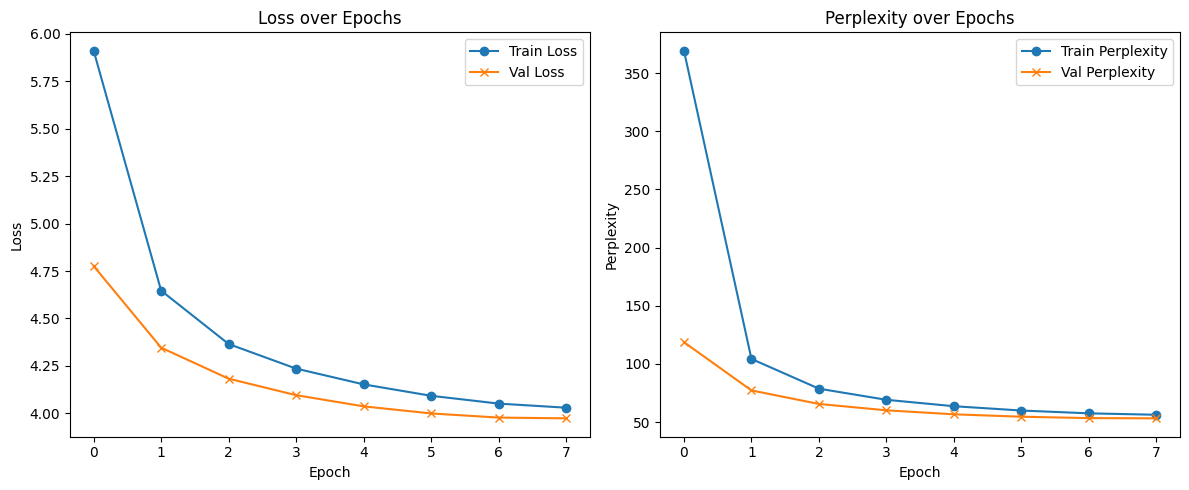

In [55]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(losses_per_epoch, label='Train Loss', marker='o')
plt.plot(val_losses_per_epoch, label='Val Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Perplexity Plot
plt.subplot(1, 2, 2)
plt.plot(perplexities_per_epoch, label='Train Perplexity', marker='o')
plt.plot(val_perplexities_per_epoch, label='Val Perplexity', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity over Epochs")
plt.legend()

plt.tight_layout()
plt.savefig("loss_perplexity_plot.png")
plt.show()

The above loss and perplexity over time seems good that the model generalizes well

In [56]:
def test_model(model, test_loader, num_batches, vocab_size, device,
               tokenizer=None, tokenizer_type="word", num_samples_to_store=30):
    model.eval()
    test_loss = 0.0
    total_tokens = 0

    results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, total=num_batches, desc="🧪 Testing"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            # Compute loss and token count
            # loss, token_count = get_loss_and_masks(input_ids, labels, model, vocab_size)
            loss, token_count = get_loss_and_masks(input_ids, labels, model, vocab_size, loss_fn, pad_token_id)

            test_loss += loss.item()
            total_tokens += token_count

            # Collect examples for analysis
            if len(results) < num_samples_to_store:
                for i in range(min(len(input_ids), num_samples_to_store - len(results))):
                    input_seq = input_ids[i].tolist()
                    label_seq = labels[i].tolist()

                    # Decode label (target sentence)
                    if tokenizer_type == "word":
                        inv_vocab = {v: k for k, v in tokenizer.word_index.items()}
                        target_text = ' '.join(inv_vocab.get(tok, "<UNK>") for tok in label_seq if tok != pad_token_id)
                    else:
                        target_text = tokenizer.decode(label_seq, skip_special_tokens=True)

                    # Generate model prediction
                    prediction = generate_sentence(model, tokenizer, tokenizer_type)

                    results.append({
                        "ground_truth": target_text,
                        "prediction": prediction
                    })

    print("Test loss:", test_loss)
    print("Total tokens:", total_tokens)

    test_avg_loss = test_loss / total_tokens
    test_ppl = compute_perplexity(test_loss, total_tokens)

    return test_avg_loss, test_ppl, results


In [57]:
print("\nTraining Complete! Final Samples:")
for _ in range(10):
    print("📝", generate_sentence(transformer_model, tokenizer, tokenizer_type))



Training Complete! Final Samples:
📝 the nsb stopped at the war monuments, from which it had been built. it was so uncomfortable that large crowds were carried
📝 another suggestion is to change the lives of samantass and patago. the method is to add the shoots of fairy tales
📝 political economist joe harley wenns wrote that films such as the djbooth subplot and pisuds were not currently
📝 the castle is built primarily as a regular passenger depot but still carries 15 passengers to passengers. since then, the castle has been
📝 for most games skiago silva began the 2014 2005 season, ending in the top of the high playing field, which closed
📝 during world war i, between the end of world war ii, the british admiralty brought forward coal to a double junction and the
📝 in december, changing circumstances arose as the fall of alexander ' s wife, countess alexander, to whom osman was accused of ru
📝 in 2013, huff won reelection to nbc. the republican presidential nominee of condolence commenc

In [58]:
# D_MODEL = 256
# NUM_HEADS = 8
# NUM_LAYERS = 8
# FF_DIM = 512
# DROP_OUT = 0.1

In [59]:
# Load best model for testing
best_model = TransformerLM(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_dim=FF_DIM,
    dropout=DROP_OUT,
    max_len=MAX_LEN
).to(DEVICE)

best_model.load_state_dict(torch.load("best_model.pt"))
best_model.eval()
print("✅ Loaded best model for testing.")


✅ Loaded best model for testing.


In [60]:
test_batches = ceil(1.0 * len(test_loader))  # or just len(test_loader)

test_loss, test_ppl, test_results = test_model(
    model=best_model,
    test_loader=itertools.islice(test_loader, test_batches),
    num_batches=test_batches,
    vocab_size=vocab_size,
    device=DEVICE,
    tokenizer=tokenizer,
    tokenizer_type=tokenizer_type,
    num_samples_to_store=30
)

print("\nFinal Test Results:")
print(f" Test Loss      : {test_loss:.4f}")
print(f" Test Perplexity: {test_ppl:.2f}")


🧪 Testing: 100%|██████████| 31/31 [00:08<00:00,  3.59it/s]

Test loss: 871970.8515625
Total tokens: 218838

Final Test Results:
 Test Loss      : 3.9845
 Test Perplexity: 53.76


Here is the current benchmark results

| Model                                 | Perplexity |
|---------------------------------------|------------|
| Neural cache model (size = 2,000)     | 40.800     |
| GCNN-8                                | 30.0       |
| 4 layer QRNN                          | 28.0       |
| LSTM (Hebbian, Cache, MbPA)           | 27.0       |
| Transformer (Adaptive inputs)         | 18.7       |
| kNN-LM w/ Adaptive Coefficient        | 17.1       |


In those predictions sentences, cause i limit to the generate functions to generate be defaults just a sentence of max length 25 so you could see that they are shorter than the ground truth sentences, but the prediction quite ok i think

In [61]:
# Optional: Print stored samples
print("\n📜 Sample Predictions:")
for i, sample in enumerate(test_results):
    print(f"\n🟩 Ground Truth {i+1}: {sample['ground_truth']}")
    print(f"🟨 Prediction   {i+1}: {sample['prediction']}")



📜 Sample Predictions:

🟩 Ground Truth 1: robert boulter is an english film, television and theatre actor. he had a guest - starring role on the television series the bill in 2000. this was followed by a starring role in the play herons written by simon stephens, which was performed in 2001 at the royal court theatre. he had a guest role in the television series judge john deed in 2002. in 2004 boulter landed a role as " craig " in the episode " teddy ' s story " of the television series the long firm ; he starred alongside actors mark strong and derek jacobi. he was cast in the 2005 theatre productions of the philip ridley play mercury fur, which was performed at the drum theatre in plymouth and the chocolate factory in london. he was directed by john tiffany and starred alongside ben whishaw, shane zaza, harry kent, fraser ayres, sophie stanton and dominic hall.
🟨 Prediction   1: there were several nine different types in the rodrigues star wars adventure film, an action role directe